In [1]:
from keras.applications import * 
from keras.preprocessing.image import * 
from keras.optimizers import * 
from keras.models import *
from keras.layers import * 
img_dim_ordering = "tf"
from keras import backend as K
K.set_image_dim_ordering(img_dim_ordering)
from keras.callbacks import ModelCheckpoint

Using TensorFlow backend.


In [32]:
img_width, img_height = 299,299
nb_classes = 10 
train_data_dir = "../paperspace/Downloads/monkey_training"
validation_data_dir = "../paperspace/Downloads/monkey_validation"
testing_data_dir = "../paperspace/Downloads/monkey_testing"

nb_train_samples = 1097
nb_validation_samples = 272
nb_test_samples = 981 
#nb_test_samples = 
epochs = 5
batch_size = 16
input_tensor = Input(shape=(img_width,img_height,3))

base_model = Xception(weights='imagenet',include_top=False,input_tensor=input_tensor)
top_model = Sequential()
top_model.add(Flatten(input_shape=base_model.output_shape[1:]))
top_model.add(BatchNormalization())
top_model.add(Dense(nb_classes, activation='softmax'))

#top_model.load_weights('bootlneck_fc_model.h5')
model = Model(inputs= base_model.input, outputs= top_model(base_model.output))

In [33]:
for layer in base_model.layers:
    layer.trainable = False

In [34]:
from  PIL import  ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

#sgd=optimizers.SGD(lr=0.0001, decay=1e-6,momentum=0.9,nesterov=True)

model.compile(loss='categorical_crossentropy',
optimizer="sgd", metrics=['accuracy'])

# prepare data augmentation configuration
train_datagen = ImageDataGenerator(
                rescale=1. / 255,
                shear_range=0.2,
                zoom_range=0.2,
                horizontal_flip=True)

test_datagen = ImageDataGenerator(
                rescale=1. / 255,
                rotation_range=30,
                width_shift_range=0.2,
                height_shift_range=0.2,
                shear_range=0.2,
                zoom_range=0.2,
                horizontal_flip=True)

train_generator = train_datagen.flow_from_directory(
                  train_data_dir,
                  target_size=(img_height, img_width),
                  batch_size = batch_size,
                  class_mode='categorical')
valid_generator = test_datagen.flow_from_directory(
                  validation_data_dir,
                  target_size=(img_height, img_width),
                  batch_size=batch_size,
                  class_mode="categorical")

test_generator = test_datagen.flow_from_directory(
                 testing_data_dir,
                 target_size = (img_height, img_width),
                 batch_size = 1,
                 class_mode="categorical",
                 shuffle=False)

checkpointer = ModelCheckpoint(filepath =  "../paperspace/Downloads/monkey_weights_5.hdf5",
                               verbose = 1,
                               save_best_only = True)

filenames = test_generator.filenames
nb_samples = len(filenames)



Found 1097 images belonging to 10 classes.
Found 272 images belonging to 10 classes.
Found 981 images belonging to 10 classes.


In [35]:
# fine-tune the model
model.fit_generator(
    train_generator,
    steps_per_epoch=nb_train_samples // batch_size,
    epochs = 5,
    validation_data=valid_generator,
    nb_val_samples = nb_validation_samples,
    callbacks = [checkpointer], verbose = 1)

/home/paperspace/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  
/home/paperspace/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras.pre..., steps_per_epoch=68, epochs=5, validation_data=<keras.pre..., callbacks=[<keras.ca..., verbose=1, validation_steps=272)`
  


Epoch 1/5
68/68 [==============================] - 270s 4s/step - loss: 1.4372 - acc: 0.8416 - val_loss: 0.8039 - val_acc: 0.9026
Epoch 2/5
68/68 [==============================] - 255s 4s/step - loss: 0.5124 - acc: 0.9393 - val_loss: 0.7109 - val_acc: 0.9278
Epoch 3/5
68/68 [==============================] - 257s 4s/step - loss: 0.4068 - acc: 0.9586 - val_loss: 0.8797 - val_acc: 0.9198
Epoch 4/5
68/68 [==============================] - 255s 4s/step - loss: 0.3026 - acc: 0.9653 - val_loss: 0.9766 - val_acc: 0.9120
Epoch 5/5
68/68 [==============================] - 256s 4s/step - loss: 0.3908 - acc: 0.9625 - val_loss: 1.0991 - val_acc: 0.9076


In [36]:
model.load_weights("/home/paperspace/Downloads/monkey_weights_5.hdf5")
pred0 = model.predict_generator(test_generator,steps = nb_samples, verbose=1)

981/981 [==============================] - 43s 44ms/step


In [37]:
pred_ix = [np.argmax(z) for z in pred0]


actual_ix = [z[1] for z in filenames]
actual_ix = [int(z) for z  in actual_ix]


from sklearn.metrics import confusion_matrix

bob = confusion_matrix(pred_ix,actual_ix)
print(bob)

corrects = 0
for i in range(len(actual_ix)):
    if actual_ix[i] == pred_ix[i]:
       corrects += 1  
print("overall accuracy is",corrects/len(actual_ix))


class_accuracy = list() 
for i in range(10):
    right = bob[i,i]
    total = np.sum(bob,axis=1)[i]
    class_acc = right/total 
    class_accuracy.append(class_acc)
    

print(class_accuracy)

[[86  0  0  0  0  0  0  0  4  5]
 [ 0 93  0  0  0  0  0  1  4  1]
 [ 1  2 90  5  3  1  6  0  7  3]
 [ 0  0  0 91  2  1  1  0  0  2]
 [ 3  0  4  1 87  0 12  0 11  7]
 [ 2  0  0  1  0 93  1  0  5  3]
 [ 0  0  2  1  1  0 74  0  0  0]
 [ 2  4  0  0  2  0  2 97  6  0]
 [ 4  1  1  0  3  0  1  1 53  2]
 [ 1  0  1  0  1  1  0  0  7 74]]
overall accuracy is 0.854230377166157
[0.90526315789473688, 0.93939393939393945, 0.76271186440677963, 0.93814432989690721, 0.69599999999999995, 0.88571428571428568, 0.94871794871794868, 0.8584070796460177, 0.80303030303030298, 0.87058823529411766]


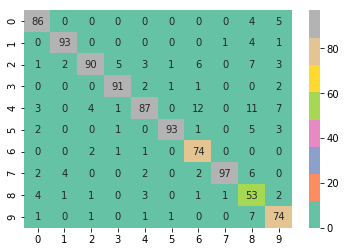

In [38]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.heatmap(bob,
            annot=True,
            cmap="Set2")
plt.show()